<a href="https://colab.research.google.com/github/prithivirajmurugan/deep-learning/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import glob
import numpy as np
import os
import shutil


np.random.seed(42)

In [50]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"prithivist","key":"b45c54ae12c7eb24c91fa202d3f23f38"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [51]:
!kaggle competitions download -c dogs-vs-cats

sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [52]:
!unzip "./train.zip"

Archive:  ./train.zip
caution: filename not matched:  -A


In [53]:

files = glob.glob('train/*.jpg') #to get all filenames 

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files),len(dog_files)

(12500, 12500)

In [54]:
#Train dataset
cat_train = np.random.choice(cat_files,size=1500,replace=False)
dog_train = np.random.choice(dog_files,size=1500,replace=False)
cat_files = list(set(cat_files)-set(cat_train))
dog_files = list(set(cat_files)-set(dog_train))
#Validation dataset
cat_val = np.random.choice(cat_files,size=500,replace=False)
dog_val = np.random.choice(dog_files,size=500,replace = False)
cat_files = list(set(cat_files)-set(cat_val))
dog_files = list(set(dog_files)-set(dog_val))

#test dataset
cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape,cat_val.shape,cat_test.shape)
print('Dog datasets:', dog_train.shape,dog_val.shape,dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [55]:
#Writing to main memory

train_dir = "train_dir"
val_dir = "val_dir"
test_dir = "test_dir"

train_files = np.concatenate([cat_train,dog_train])
validate_files = np.concatenate([cat_val,dog_val])
test_files = np.concatenate([cat_test,dog_test])


os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn,train_dir)

for fn in validate_files:
    shutil.copy(fn,val_dir)
    
for fn in validate_files:
    shutil.copy(fn,test_dir)

In [56]:
#Preparing datasets

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

%matplotlib inline

In [57]:
IMG_DIM = (150,150)

train_files = glob.glob('train_dir/*.jpg')

train_imgs = [img_to_array(load_img(img,target_size=IMG_DIM)) for img in train_files]

train_imgs = np.array(train_imgs)
train_labels=[fn.split("/")[1].split(".")[0].strip() for fn in train_files]

validation_files = glob.glob('val_dir/*.jpg')
validation_imgs = [img_to_array(load_img(img,target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels=[fn.split("/")[1].split(".")[0].strip() for fn in validation_files]
print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (974, 150, 150, 3)


(150, 150, 3)


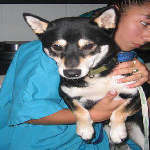

In [58]:
# Scaled each channel of RGB layer from 0 - 255 to 0 - 1
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')

train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs_scaled[0])

In [59]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150,150,3)

#encode text category labels

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505],train_labels_enc[1495:1505])

['dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat'] [1 1 1 1 0 0 1 1 1 0]


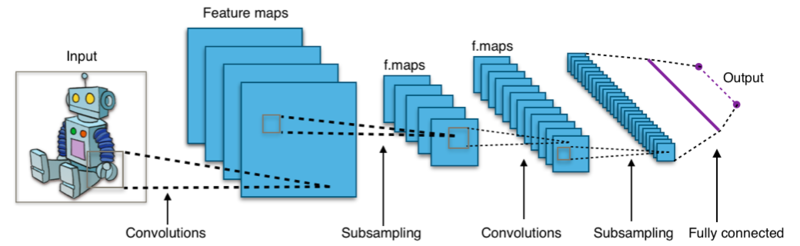

In [60]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [67]:
def create_model():
  model = Sequential()
  model.add(Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=input_shape))
  model .add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(),metrics=['accuracy'])
  model.summary()
  return model

In [75]:
def tpu_train_model(model_fun,x,y,val_x,val_y,batch_size,epochs):
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    print("TPU found")
  except ValueError:
   tpu = None
   print("TPU Not Found")
  if tpu:
   tf.tpu.experimental.initialize_tpu_system(tpu)
   strategy = tf.distribute.TPUStrategy(tpu)
   print('Running on TPU',tpu.cluster_spec().as_dict()['worker'])
  else:
   strategy = tf.distribute.get_strategy()
   print("Running on CPU instead")
  with strategy.scope():
    model = model_fun()
    history = model.fit(x=x,y=y,validation_data=(val_x,val_y),
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1)
  return history


In [76]:
history = tpu_train_model(create_model,train_imgs_scaled,train_labels_enc,validation_imgs_scaled,validation_labels_enc,batch_size,epochs)

TPU found


INFO:tensorflow:Initializing the TPU system: grpc://10.31.136.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.31.136.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU ['10.31.136.130:8470']
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_5 (Flatt

In [77]:
def draw_graph(history,epochs):
    
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

    t = f.suptitle('Basic CNN Performance',fontsize=12)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list,history.history['accuracy'],label='Train Accuracy')
    ax1.plot(epoch_list,history.history['val_accuracy'],label='Validation Accuracy')
    ax1.set_xticks(np.arange(0,epochs+1,5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1 , 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

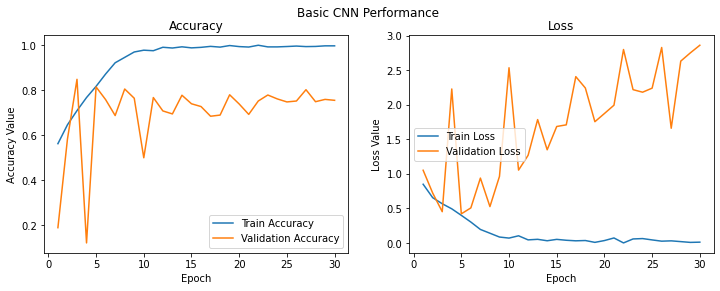

In [78]:
draw_graph(history,epochs)

In [79]:
# Model shows over fitting after  2-3 epochs hence using regularization "Drop-out" in dense layer
def create_model_with_reg():
  model = Sequential()

  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))


  model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])
  return model
              
#history = tpu_train_model()             
#history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    #validation_data=(validation_imgs_scaled, validation_labels_enc),
                    #batch_size=batch_size,
                    #epochs=epochs,
                    #verbose=1)  

In [80]:
history = tpu_train_model(create_model_with_reg,train_imgs_scaled,train_labels_enc,validation_imgs_scaled,validation_labels_enc,batch_size,epochs)

TPU found


INFO:tensorflow:Initializing the TPU system: grpc://10.31.136.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.31.136.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU ['10.31.136.130:8470']
Epoch 1/30
100/100 [==============================] - 16s 103ms/step - loss: 0.7546 - accuracy: 0.4877 - val_loss: 0.7541 - val_accuracy: 0.0883
Epoch 2/30
100/100 [==============================] - 3s 30ms/step - loss: 0.6951 - accuracy: 0.5829 - val_loss: 0.6349 - val_accuracy: 0.6047
Epoch 3/30
100/100 [==============================] - 3s 30ms/step - loss: 0.6543 - accuracy: 0.6397 - val_loss: 0.6220 - val_accuracy: 0.6006
Epoch 4/30
100/100 [==============================] - 3s 30ms/step - loss: 0.6190 - accuracy: 0.6807 - val_loss: 0.2811 - val_accuracy: 0.9559
Epoch 5/30
100/100 [==============================] - 3s 31ms/step - loss: 0.5886 - accuracy: 0.7126 - val_loss: 0.3087 - val_accuracy: 0.9076
Epoch 6/30
100/100 [==============================] - 3s 31ms/step - loss: 0.5485 - accuracy: 0.7438 - val_loss: 0.5022 - val_accuracy: 0.7546
Epoch 7/30
100/100 [==============================] - 3s 31ms/step - loss: 0.4995 - accuracy: 0.7635 -

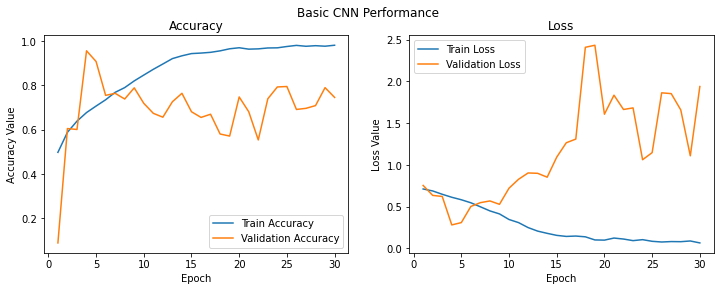

In [81]:
draw_graph(history,epochs)

In [83]:
model.save("cats_dogs_basic_cnn.h5")

In [84]:
#Image Augumentation
train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.3,rotation_range=50,
                                  width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,
                                  horizontal_flip=True,fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

#zoom randomly by a factor of 0.3
#rotate image randomly by 50 degrees
#Translate image randomly horizontally and vertically by 0.2
#apply shear-based transformation randomly 
#horizontal flipping
#fill new pixels for image after the preceding the operation


Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


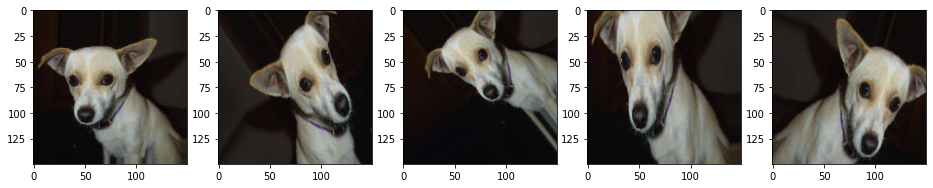

In [85]:
#test image generator
img_id = 500

cat_generator = train_datagen.flow(train_imgs[img_id : img_id + 1],train_labels[img_id:img_id+1],batch_size=1)

cat = [next(cat_generator) for i in range(0,5)]

fig,ax = plt.subplots(1,5,figsize=(16,6))
print('Labels:',[item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


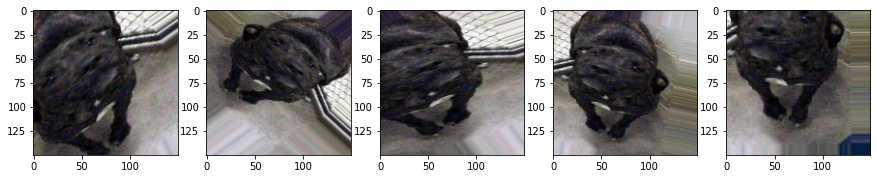

In [86]:
img_id = 1991
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

In [95]:
# training

train_generator = train_datagen.flow(train_imgs,train_labels_enc,batch_size=30)
val_generator = val_datagen.flow(validation_imgs,validation_labels_enc,batch_size=20)
input_shape=(150,150,3)

def create_model_with_aug():
   
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['accuracy'])
    
    model.summary()

    return model



In [102]:
def tpu_train_model_with_gen(model_fun,
                             steps_per_epoch,
                             validation_steps,
                             epochs):
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    print("TPU found")
  except ValueError:
   tpu = None
   print("TPU Not Found")
  if tpu:
   tf.tpu.experimental.initialize_tpu_system(tpu)
   strategy = tf.distribute.TPUStrategy(tpu)
   print('Running on TPU',tpu.cluster_spec().as_dict()['worker'])
  else:
   strategy = tf.distribute.get_strategy()
   print("Running on CPU instead")
  with strategy.scope():
    train_generator = train_datagen.flow(train_imgs,train_labels_enc,batch_size=30)
    val_generator = val_datagen.flow(validation_imgs,validation_labels_enc,batch_size=20)
    input_shape=(150,150,3)
    model = model_fun()
    history = model.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=val_generator,
                        validation_steps=validation_steps,
                        epochs=epochs,
                        verbose=1)
  return history

In [103]:
history = tpu_train_model_with_gen(create_model_with_aug,
                                   steps_per_epoch=100,
                                   epochs=100,
                                   validation_steps=50)

TPU found


INFO:tensorflow:Initializing the TPU system: grpc://10.31.136.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.31.136.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU ['10.31.136.130:8470']
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_49 (Conv

UnavailableError: ignored

In [ ]:
draw_graph(history,100)

In [ ]:
model.save('cats_dogs_cnn_img_aug.h5')

# Transfer Learning using VGG16 Model

In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras as keras

vgg = vgg16.VGG16(include_top=False,weights='imagenet',input_shape=input_shape)

In [ ]:
output = vgg.layers[-1].output

output = keras.layers.Flatten()(output)

vgg_model = Model(vgg.input,output)

vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
import pandas as pd

pd.set_option('max_colwidth',-1)
layers = [(layer ,layer.name,layer.trainable)for layer in vgg_model.layers]
pd.DataFrame(layers,columns=['Layer Type','Layer Name','Layer Trainable'])

In [ ]:
#bottleneck features - from block5_pool which is flattened
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [ ]:
def get_bottleneck_features(model,input_imgs):
    features = model.predict(input_imgs,verbose=0)
    return features

train_features_vgg = get_bottleneck_features(vgg_model,train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model,validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

In [ ]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512,activation='relu',input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

In [ ]:
draw_graph(history,epochs)
model.save('cats_dogs_tlearn_basic_cnn.h5')

# With Image Augumentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.3,rotation_range=50,
                                  width_shift_range=0.2,height_shift_range=0.2,
                                  shear_range=0.2,horizontal_flip=True,
                                  fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs,train_labels_enc,batch_size=30)
val_generator = val_datagen.flow(validation_imgs,validation_labels_enc,batch_size=20)

In [ ]:
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()
          

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)

In [ ]:
draw_graph(history,100)
model.save('cats_dogs_tlearn_img_aug_cnn.h5')

In [ ]:
# Fine tuning
vgg_model.trainable=True

set_trainable=False

for layer in vgg_model.layers:
    if layer.name in ['block5_conv1','block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
layers = [(layer,layer.name,layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers,columns=['Layer Type','Layer Name','Layer Trainable'])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [ ]:
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)

draw_graph(history,100)
model.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

# Evaluating models using Test data

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array,array_to_img
from tensorflow.keras.models import load_model
import model_evaluation_utils as meu
%matplotlib inline

#load saved models

basic_cnn = load_model('cats_dogs_basic_cnn.h5')
img_aug_cnn = load_model('cats_dogs_cnn_img_aug.h5')
tl_cnn = load_model('cats_dogs_tlearn_basic_cnn.h5')
tl_img_aug_cnn = load_model('cats_dogs_tlearn_img_aug_cnn.h5')
tl_img_aug_finetune_cnn = load_model('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

#loading configurations

IMG_DIM = (150,150)
input_shape = (150,150,3)

num2class_label_transformer = lambda l : ['cat' if x == 0 else 'dog' for x in l]

class2num_label_transformer = lambda l : [0 if x == 'cat' else 1 for x in l]

#load VGG model for bottleneck features

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras as keras

vgg = vgg16.VGG16(include_top=False,weights='imagenet',input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [ ]:
IMG_DIM = (150,150)

test_files = glob.glob('test_dir/*')
test_imgs = [img_to_array(load_img(img,target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[1].split('.')[0].strip() for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255
test_labels_enc = class2num_label_transformer(test_labels)

print('Test dataset shape:',test_imgs.shape)
print(test_labels[0:5],test_labels_enc[0:5])

In [ ]:
#Basic CNN performance
predictions = basic_cnn.predict_classes(test_imgs_scaled,verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels,predicted_labels=predictions,
                                     classes = list(set(test_labels)))

In [ ]:
#CNN with image augumentation performance
predictions = img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

In [ ]:
#Transfer Learning — Pre-trained CNN as a Feature Extractor Performance
test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)

predictions = tl_cnn.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

In [ ]:
# Transfer Learning — Pre-trained CNN as a Feature Extractor with Image Augmentation Performance
predictions = tl_img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

In [ ]:
# ransfer Learning — Pre-trained CNN with Fine-tuning and Image Augmentation Performance
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

In [ ]:
# worst model - basic CNN 
meu.plot_model_roc_curve(basic_cnn, test_imgs_scaled, 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1]) 

# best model - transfer learning with fine-tuning & image augmentation 
meu.plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled, 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1])